# Notebook to format data provided by Baglione lab. Currently unpublished

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal
import scipy.io as sio
from pathlib import Path
import IPython.display as ipd
import librosa
from tqdm import tqdm

In [4]:
# Specify data filepaths

#raw_data_dir = Path('/home/jupyter/behavior_data_local/data/raw/baglione_crows')
raw_data_dir = Path('/home/jupyter/data/19/')
formatted_data_dir = Path('/home/jupyter/behavior_data_local/data/formatted/baglione_crows')

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
#annotations_fp = raw_data_dir.joinpath('labelled_datasets_individual_vocalizations_classification_with_file.csv')
annotations_fp = '/home/jupyter/carrion_crow_annotation/proposed_annotations.csv'

data_fps = ['/home/jupyter/data/19/BUCK/Rosa/1011.swv',
            '/home/jupyter/data/19/BV/Morado/1008.swv',
            '/home/jupyter/data/19/BD/Rosa/1004.swv', 
            '/home/jupyter/data/19/BD/Rosa/1005.swv']

data_fps = [Path(x) for x in data_fps]
# data_fps = list(raw_data_dir.joinpath('data').glob('**/*.swv'))


In [5]:
# Dataset metadata
dataset_metadata = {}
sr = 50 # They provide up to 200 Hz, but we use 50
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'baglione_crows'

In [6]:
# Convenience functions

def data_fp_to_clip_id(x):
    return x.parent.parent.name + '_' + x.parent.name + '_' + x.stem

# def clip_id_to_data_fp(y):
#     y = y.split('_')
#     return raw_data_dir.joinpath('data').joinpath('19').joinpath(y[0]).joinpath(y[1]).joinpath(y[2]+'.swv')

def clip_id_to_data_fp(y):
    y = y.split('_')
    return raw_data_dir.joinpath(y[0]).joinpath(y[1]).joinpath(y[2]+'.swv')

In [7]:
# Prep annotations

all_annotations = pd.read_csv(annotations_fp)

#
all_annotations['file'] = all_annotations['fp']
#

def annotations_get_clip_id(x):
    x = x.split('/')
    return '_'.join([x[-3], x[-2], x[-1].split('.')[0]])

all_annotations['clip_id'] = all_annotations['file'].map(annotations_get_clip_id)


# Subselect for files with most vocalizations, to reduce dataset size
subselect_ids = all_annotations['clip_id'].value_counts()[:100].keys()
#assert len(set([x[:-5] for x in subselect_ids])) == 9, 'dropped at least one individual!'

In [8]:
subselect_ids

Index(['BUCK_Rosa_1011', 'BV_Morado_1008', 'BD_Rosa_1004', 'BD_Rosa_1005'], dtype='object')

In [9]:
# Compute duration
# Simultaneously, we remove the files that have few vocalizations, to reduce the dataset size

data_fps_subselected = []

length = 0
for fp in tqdm(data_fps):
    # load features
    x = librosa.load( fp, sr = 50, mono = False)[0]
    l = np.shape(x)[1]
    clip_id = data_fp_to_clip_id(fp)
    if clip_id in subselect_ids:
        length += l
        data_fps_subselected.append(fp)

total_dur_sec = length / 50 
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

data_fps = data_fps_subselected

100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

total duration is 47092.800000 seconds, i.e. 13.081333 hours


In [10]:
data_fps

[PosixPath('/home/jupyter/data/19/BUCK/Rosa/1011.swv'),
 PosixPath('/home/jupyter/data/19/BV/Morado/1008.swv'),
 PosixPath('/home/jupyter/data/19/BD/Rosa/1004.swv'),
 PosixPath('/home/jupyter/data/19/BD/Rosa/1005.swv')]

In [11]:
# Get list of clip ids

clip_ids = sorted([data_fp_to_clip_id(x) for x in data_fps])

# data_fps = [raw_data_dir + '/' + clip_id + '/' +clip_id +'prh_speed.mat' for clip_id in clip_ids]

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [12]:
## Integer codes for individuals

clip_id_to_individual = {}
for clip_id in clip_ids:
    y = clip_id.split('_')
    clip_id_to_individual[clip_id] = y[0] + '_' + y[1]
     
individuals = sorted(set(clip_id_to_individual[y] for y in clip_ids))

## Integer codes for individuals

individual_to_individual_id = {individual : i for i, individual in enumerate(individuals)}
clip_id_to_individual_id = {clip_id : individual_to_individual_id[clip_id_to_individual[clip_id]] for clip_id in clip_ids}
    

dataset_metadata['individual_ids'] = [individual_to_individual_id[x] for x in individuals]
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

In [13]:
# Set up data splits by individual

test_proportion = .25
val_proportion = .25
num_individuals = len(individuals)

test_num_individuals = int(test_proportion * num_individuals)
val_num_individuals = int(val_proportion * num_individuals)

rng = np.random.default_rng(61) #60
test_individuals = list(rng.choice(individuals, size = test_num_individuals, replace = False))
test_individuals.sort()

dev_individuals = individuals.copy()
for i in test_individuals:
    dev_individuals.remove(i)
    
val_individuals = list(rng.choice(dev_individuals, size = val_num_individuals, replace = False))
val_individuals.sort()
    
train_individuals = dev_individuals.copy()
for i in val_individuals:
    train_individuals.remove(i)
    
train_individuals = ['BUCK_Rosa']
val_individuals = ['BV_Morado']
dev_individuals = train_individuals + val_individuals
test_individuals = ['BD_Rosa']

print(train_individuals)
print(val_individuals)
print(dev_individuals)
print(test_individuals)

['BUCK_Rosa']
['BV_Morado']
['BUCK_Rosa', 'BV_Morado']
['BD_Rosa']


In [14]:
# Set up clip ids 

# Clip ids
test_clip_ids = []
train_clip_ids = []
val_clip_ids = []
dev_clip_ids = []
for clip_id in clip_ids:
    individual = clip_id_to_individual[clip_id]
    if individual in train_individuals:
        train_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in val_individuals:
        val_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in test_individuals:
        test_clip_ids.append(clip_id)
    
train_clip_ids.sort()
val_clip_ids.sort()
dev_clip_ids.sort()
test_clip_ids.sort()
    
dataset_metadata['clip_ids'] = clip_ids
dataset_metadata['train_clip_ids'] = train_clip_ids
dataset_metadata['test_clip_ids'] = test_clip_ids
dataset_metadata['val_clip_ids'] = val_clip_ids
dataset_metadata['dev_clip_ids'] = dev_clip_ids

## Create dataset-level metadata

In [15]:
## Integer codes for specific behaviors

beh_names = ['unknown',
             'flying',
             'in_nest']

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}


In [16]:
## clip_data column names
## Since Pitch and Roll are provided, we include them
## Omit Head, likely irrelevant

clip_column_names = ['AccX', 'AccY', 'AccZ', 'StaticAccX', 'StaticAccY', 'StaticAccZ', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [17]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

## Format Clip Data

In [18]:
# use butterworth filter to extract low and high frequency components
def extract_static(series, low_cutoff_freq):
    # extract static component
    sos = signal.butter(10, low_cutoff_freq, 'low', fs=sr, output='sos')
    low_passed_series = signal.sosfilt(sos, series)
    remaining_series = series - low_passed_series
    return low_passed_series, remaining_series

# Convenience function to detect nans.
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

#Interpolates all nan values of given array
def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

In [19]:
# all_annotations['class'] = all_annotations['class'].map(lambda x: int(x))
all_annotations['class'] = all_annotations['label'].map(lambda x: int(x))

In [20]:
# For each clip, create and save the data in the correct format

for clip_id in tqdm(clip_ids):
    # load features
    data_fp = clip_id_to_data_fp(clip_id)
    data  = librosa.load(data_fp, sr = 50, mono = False)[0]
    Ax = data[0, :].flatten() ## The logger records the swv file at 50 Hz but the accelerometer channels are at 200 Hz. Then, the first 4 samples of acc X axis are the first samples in channels 0,3,6,10.
    Ay = data[1, :].flatten()
    Az = data[2, :].flatten()
    
    dur = len(Ax)
    
    clip_data = np.zeros((dur, 8))
    
    # correct for gravity
    for i, x in enumerate([Ax, Ay, Az]): 
        to_correct = x
        to_correct = interpolate_nan(to_correct)
        static, corrected = extract_static(to_correct, 0.3)
        clip_data[:, i] = corrected
        clip_data[:, i+3] = static
        
    # # Possible calibration step: Normalize so on average static components have constant magnitude (on sphere of radius 1)
    # #
    # static_mag = np.mean(np.sqrt(clip_data[:,3]**2 + clip_data[:,4]**2 + clip_data[:,5]**2))
    # clip_data = clip_data/static_mag
    # #
    
    # load annotations
    annotations_sub = all_annotations[all_annotations['clip_id'] == clip_id]
    
    # reformat annotations
    # per_frame_annotations = np.ones(dur) # populate with 1's, aka "not_vocalizing"
    # for i, row in annotations_sub.iterrows():
    #     if row['class'] in [2, 32, 7, 28, 29, 45]:
    #         int_label = 2
    #     else:
    #         int_label = 0
    #     start_sample = int(row['start.in.file']*sr)
    #     end_sample = int(row['end.in.file'] * sr)
    #     per_frame_annotations[start_sample: end_sample] = int_label
    #     # Pad before and after with unknowns
    #     pad_dur_sec = 2
    #     pad_dur_samples = int(pad_dur_sec * sr)
    #     start_pad = start_sample - pad_dur_samples
    #     end_pad = end_sample + pad_dur_samples
    #     # hacky way to set everything that is not label 2 to be 0:
    #     per_frame_annotations[start_pad:end_pad] = np.maximum(per_frame_annotations[start_pad:end_pad] - 1, 0) * 2
    
    per_frame_annotations = np.zeros(dur) # populate with 0's, aka "unknown"
    for i, row in annotations_sub.iterrows():
        int_label = row['class']
        start_sample = int(row['start_sec']*sr)
        end_sample = int(row['end_sec'] * sr)
        per_frame_annotations[start_sample: end_sample] = int_label

    clip_data[:, -1] = per_frame_annotations

    # insert individual id
    individual_id = clip_id_to_individual_id[clip_id]
    clip_data[:, -2] = individual_id
    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    np.savetxt(clip_data_fp, clip_data, delimiter=",", fmt='%.9e')

100%|██████████| 4/4 [00:16<00:00,  4.14s/it]


## Check it all looks ok

In [21]:
clip_id = clip_ids[-1]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.array(pd.read_csv(clip_data_fp, delimiter = ',', header = None))
#data = np.load(clip_data_fp)

In [22]:
np.shape(data)

(855945, 8)

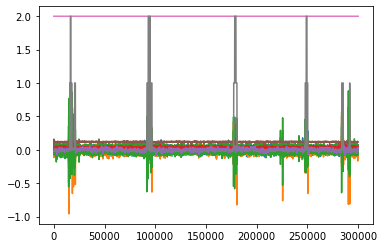

In [23]:
for i in range(np.shape(data)[1]):
    plt.plot(data[:300000, i])

## Plot Dataset Summary

In [24]:
# Count class representation

beh_names = dataset_metadata['label_names']
train_label_count = {name : 0 for name in beh_names}
val_label_count = {name : 0 for name in beh_names}
dev_label_count = {name : 0 for name in beh_names}
test_label_count = {name : 0 for name in beh_names}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        if clip_id in dataset_metadata['train_clip_ids']:
            train_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['val_clip_ids']:
            val_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['test_clip_ids']:
            test_label_count[name] += counts[key]

train_label_perc = {name : 0 for name in beh_names[1:]}
val_label_perc = {name : 0 for name in beh_names[1:]}
dev_label_perc = {name : 0 for name in beh_names[1:]}
test_label_perc = {name : 0 for name in beh_names[1:]}

for name in beh_names[1:]:
    train_label_perc[name] = float(train_label_count[name] / sum([train_label_count[j] for j in beh_names[1:]]))
    val_label_perc[name] = float(val_label_count[name] / sum([val_label_count[j] for j in beh_names[1:]]))
    dev_label_perc[name] = float(dev_label_count[name] / sum([dev_label_count[j] for j in beh_names[1:]]))
    test_label_perc[name] = float(test_label_count[name] / sum([test_label_count[j] for j in beh_names[1:]]))

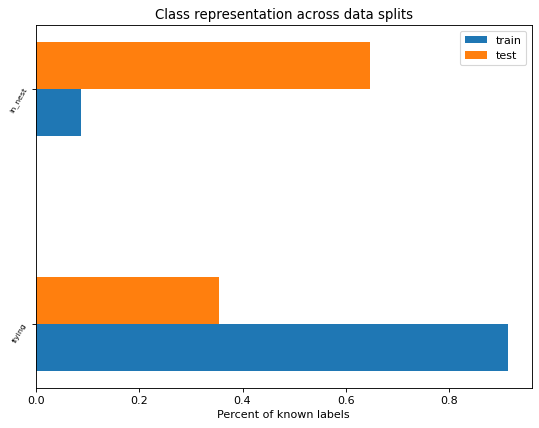

In [25]:
# Plot class representation

keys = np.arange(len(beh_names))[1:]
offset = 0.1
width = 0.2
plt.figure(figsize=(8, 6), dpi=80)

plt.barh(keys - offset, [dev_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'train') #We call dev set 'train' in the paper
#plt.barh(keys, [val_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'val')
plt.barh(keys + offset, [test_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'test')
plt.title("Class representation across data splits")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.png')

plt.savefig(target_fp)
plt.show()

numerical_target_fp = os.path.join(formatted_data_dir, 'class_rep.yaml')
class_rep_dict = {'train_label_perc' : train_label_perc,
                  'val_label_perc' : val_label_perc,
                  'dev_label_perc' : dev_label_perc,
                  'test_label_perc' : test_label_perc}
with open(numerical_target_fp, 'w') as file:
    yaml.dump(class_rep_dict, file)

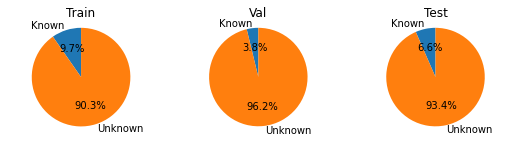

In [26]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,3, figsize = (9,2))
plt.title("blah")

ax[0].pie(train_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Train')

ax[1].pie(val_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Val')

ax[2].pie(test_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[2].set_title('Test')

target_fp = os.path.join(formatted_data_dir, 'perc_known.png')

plt.savefig(target_fp)

plt.show()


## Temporal Statistics

In [27]:
####################################
infill_max_dur_sec = 0 # If annotations are nnnnn0000000nnnnn, where 0=unknown, do we fill in 0's with n's?
####################################

# This cell runs almost as a stand alone, but requires the first few cells of this notebook to be run first

import tqdm
from pathlib import Path

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'r') as file:
    metadata = yaml.safe_load(file)

clip_fps = list(Path(clip_data_dir).glob('*.csv'))

def create_list_of_durations(x, infill_max_dur_sec, samplerate, unknown_value = 0):
    # First pass: create a list of label durations, together with a list of the associated classes
    current_value = 0
    current_dur = 0
    list_of_durs = []
    list_of_labels = []
    for i in x:
        if i == current_value:
            current_dur += 1
        elif i != current_value:
            list_of_durs.append(current_dur / samplerate)
            list_of_labels.append(current_value)
            current_dur = 1
            current_value = i
            
    list_of_durs.append(current_dur)
    list_of_labels.append(current_value)
            
    # repeatedly merge similar labels if they are seperated by unknowns of short duration
    # This is mainly to deal with duty cycling of observations
    infill_max_dur_samples = int(infill_max_dur_sec * samplerate)
    
    if list_of_labels[0] == unknown_value:
        del list_of_labels[0]
        del list_of_durs[0]
        
    if list_of_labels[-1] == unknown_value:
        del list_of_labels[-1]
        del list_of_durs[-1]
    
    j = 1
    while j<len(list_of_labels)-1:
        if list_of_labels[j] != unknown_value:
            j+= 1
        elif list_of_labels[j-1] == list_of_labels[j+1] and list_of_durs[j] < infill_max_dur_samples:
            # merge if it's a short interval of unknowns between two of the same label
            list_of_durs[j-1] += list_of_durs[j+1]
            del list_of_durs[j+1]
            del list_of_durs[j]
            del list_of_labels[j+1]
            del list_of_labels[j]
        else:
            # otherwise, drop the unknown segment
            del list_of_durs[j]
            del list_of_labels[j]

    return list_of_labels, list_of_durs # list of annotation durations, in samples.
                             
durs_sec_by_individual = {i : [] for i in metadata['individual_ids']}
overall_durs_sec = []
    
for fp in tqdm.tqdm(clip_fps):
    clip_id = fp.stem
    individual_id = metadata['clip_id_to_individual_id'][clip_id]
    clip_annotations = list(pd.read_csv(fp, header = None).values[:, -1])
    l, d = create_list_of_durations(clip_annotations, infill_max_dur_sec, metadata['sr'])
    durs_sec_by_individual[individual_id].extend(d)
    overall_durs_sec.extend(d)
    
mean_dur_sec_by_individual = {i : float(np.mean(durs_sec_by_individual[i])) for i in durs_sec_by_individual}
mean_overall_dur_sec = float(np.mean(overall_durs_sec))

metadata['mean_dur_sec_by_individual'] = mean_dur_sec_by_individual
metadata['mean_overall_dur_sec'] = mean_overall_dur_sec

print("Mean overall label duration is %0.3f seconds" % mean_overall_dur_sec)

print("Re-saving metadata to %s" % str(dataset_metadata_fp))

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(metadata, file)

100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

Mean overall label duration is 12.008 seconds
Re-saving metadata to /home/jupyter/behavior_data_local/data/formatted/baglione_crows/dataset_metadata.yaml


In [28]:
# Save off summary stats

summary_fp = '/home/jupyter/BEBE-datasets/summaries.yaml'
summary_dict = {}
summary_dict['overall_durs_sec'] = overall_durs_sec

if not os.path.exists(summary_fp):
    with open(summary_fp, 'w') as file:
        yaml.dump({}, file)
        
with open(summary_fp, 'r') as file:
    summaries = yaml.safe_load(file)
    
summaries['Crows'] = summary_dict

with open(summary_fp, 'w') as file:
    yaml.dump(summaries, file)
